# Part 2: 時空處理與儲存優化

這個 notebook 會介紹：

1. **時間 Resampling**：hourly → daily，計算統計量
2. **空間 Reproject**：
3. **多檔案讀取**：使用多年資料
4. **空間統計**：區域平均、gradient 計算
5. **Rechunking 策略**：根據分析模式調整 chunk
6. **儲存為 Zarr**：優化 metadata 和壓縮設定

---

## 學習目標

- 掌握 `.resample()` 和 `.groupby()` 的時間聚合
- 理解多檔案讀取的記憶體管理
- 學會選擇合適的 chunking 策略
- 正確儲存中間結果，避免重複計算

## 0. 環境準備

In [1]:
import dask
from dask.distributed import Client
import xarray as xr
import intake
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# 啟動 Dask Client
client = Client(processes=False, n_workers=4, threads_per_worker=2, memory_limit='4GB')
print(f"Dask Dashboard: {client.dashboard_link}")

# 載入 catalog
catalog = intake.open_catalog('catalog.yaml')

Dask Dashboard: http://140.112.13.64:8787/status


## 1. 時間 Resampling：Hourly → Daily

### 為什麼需要 Resampling？

原始 ERA5 資料是 hourly，但許多分析需要：
- **Daily mean**：日平均溫度、濕度
- **Daily max**：日最大 CAPE（對流潛勢）
- **Daily accumulation**：日累積降雨

Resampling 的優勢：
1. **減少資料量**：8760 hours → 365 days (減少 24 倍)
2. **降低雜訊**：平滑短期波動
3. **符合分析需求**：許多氣候指標是 daily 尺度

### Xarray 的 `.resample()` 方法

`.resample()` 類似 pandas，但是 **lazy** 的：
```python
ds.resample(time='1D').mean()  # 不會立即執行
```

In [2]:
# 載入 2019 年資料
# ds = catalog.era5_2019_raw.to_dask() # 你可以拿取比較兩者的速度
ds = catalog.era5_2019_chunked.to_dask()


print("原始資料：")
print(f"  Time range: {ds.time.values[0]} to {ds.time.values[-1]}")
print(f"  Time steps: {len(ds.time)}")
print(f"  Frequency: hourly")
print(f"  Size: {ds.nbytes / 1e9:.2f} GB")

原始資料：
  Time range: 2019-01-01T00:00:00.000000000 to 2019-12-31T23:00:00.000000000
  Time steps: 8760
  Frequency: hourly
  Size: 21.84 GB


### 1.1 計算 Daily Mean

In [3]:
# Daily mean
ds_daily_mean = ds.resample(time='1D').mean()

print("Daily mean:")
print(f"  Time steps: {len(ds_daily_mean.time)}")
print(f"  Size: {ds_daily_mean.nbytes / 1e9:.2f} GB")
print(f"  Reduction: {ds.nbytes / ds_daily_mean.nbytes:.1f}x")
print()
print(ds_daily_mean)

Daily mean:
  Time steps: 365
  Size: 0.91 GB
  Reduction: 24.0x

<xarray.Dataset> Size: 910MB
Dimensions:                                (time: 365, latitude: 121,
                                            longitude: 161, level: 4)
Coordinates:
  * time                                   (time) datetime64[ns] 3kB 2019-01-...
  * latitude                               (latitude) float32 484B 40.0 ... 10.0
  * longitude                              (longitude) float32 644B 100.0 ......
  * level                                  (level) int64 32B 300 500 700 850
Data variables: (12/17)
    100m_u_component_of_wind               (time, latitude, longitude) float32 28MB dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    100m_v_component_of_wind               (time, latitude, longitude) float32 28MB dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    10m_u_component_of_wind                (time, latitude, longitude) float32 28MB dask.array<chunksize=(1, 121, 161), meta=np.ndarra

### 1.2 不同變數使用不同統計量

對於對流預報，我們可能需要：
- **CAPE**: daily maximum（最大不穩定度）
- **CIN**: daily mean（平均抑制）
- **K-index**: daily mean
- **BLH**: daily maximum（最高邊界層）

Xarray 允許對不同變數做不同操作：

In [4]:
ds

<xarray.Dataset> Size: 22GB
Dimensions:                                (time: 8760, latitude: 121,
                                            longitude: 161, level: 4)
Coordinates:
  * time                                   (time) datetime64[ns] 70kB 2019-01...
  * latitude                               (latitude) float32 484B 40.0 ... 10.0
  * longitude                              (longitude) float32 644B 100.0 ......
  * level                                  (level) int64 32B 300 500 700 850
Data variables: (12/17)
    100m_u_component_of_wind               (time, latitude, longitude) float32 683MB dask.array<chunksize=(360, 121, 161), meta=np.ndarray>
    100m_v_component_of_wind               (time, latitude, longitude) float32 683MB dask.array<chunksize=(360, 121, 161), meta=np.ndarray>
    10m_u_component_of_wind                (time, latitude, longitude) float32 683MB dask.array<chunksize=(360, 121, 161), meta=np.ndarray>
    10m_v_component_of_wind                (time, latitude, longitude) float32 683MB dask.array<chunksize=(360, 121, 161), meta=np.ndarray>
    boundary_layer_height                  (time, latitude, longitude) float32 683MB dask.array<chunksize=(360, 121, 161), meta=np.ndarray>
    convective_available_potential_energy  (time, latitude, longitude) float32 683MB dask.array<chunksize=(360, 121, 161), meta=np.ndarray>
    ...                                     ...
    specific_humidity                      (time, level, latitude, longitude) float32 3GB dask.array<chunksize=(360, 4, 121, 161), meta=np.ndarray>
    surface_pressure                       (time, latitude, longitude) float32 683MB dask.array<chunksize=(360, 121, 161), meta=np.ndarray>
    temperature                            (time, level, latitude, longitude) float32 3GB dask.array<chunksize=(360, 4, 121, 161), meta=np.ndarray>
    total_precipitation                    (time, latitude, longitude) float32 683MB dask.array<chunksize=(360, 121, 161), meta=np.ndarray>
    u_component_of_wind                    (time, level, latitude, longitude) float32 3GB dask.array<chunksize=(360, 4, 121, 161), meta=np.ndarray>
    v_component_of_wind                    (time, level, latitude, longitude) float32 3GB dask.array<chunksize=(360, 4, 121, 161), meta=np.ndarray>
Attributes:
    last_updated:           2025-07-18 02:02:45.511267+00:00
    valid_time_start:       1940-01-01
    valid_time_stop:        2025-04-30
    valid_time_stop_era5t:  2025-07-12

In [4]:
# 分別計算
cape_daily_max = ds['convective_available_potential_energy'].resample(time='1D').max()
cin_daily_mean = ds['convective_inhibition'].resample(time='1D').mean()
kindex_daily_mean = ds['k_index'].resample(time='1D').mean()
blh_daily_max = ds['boundary_layer_height'].resample(time='1D').max()

# 合併成新的 Dataset (把多個 DataArray 包成一個 Dataset)
ds_daily = xr.Dataset({
    'cape_max': cape_daily_max,
    'cin_mean': cin_daily_mean,
    'kindex_mean': kindex_daily_mean,
    'blh_max': blh_daily_max
})

print("Custom daily statistics:")
print(ds_daily)

Custom daily statistics:
<xarray.Dataset> Size: 114MB
Dimensions:      (latitude: 121, longitude: 161, time: 365)
Coordinates:
  * latitude     (latitude) float32 484B 40.0 39.75 39.5 ... 10.5 10.25 10.0
  * longitude    (longitude) float32 644B 100.0 100.2 100.5 ... 139.8 140.0
  * time         (time) datetime64[ns] 3kB 2019-01-01 2019-01-02 ... 2019-12-31
Data variables:
    cape_max     (time, latitude, longitude) float32 28MB dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    cin_mean     (time, latitude, longitude) float32 28MB dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    kindex_mean  (time, latitude, longitude) float32 28MB dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    blh_max      (time, latitude, longitude) float32 28MB dask.array<chunksize=(1, 121, 161), meta=np.ndarray>


### 1.3 執行並視覺化結果

我們選取台灣附近區域，計算並繪圖。

In [5]:
ds_taiwan_july = ds_daily.sel(
    time='2019-07',
    latitude=slice(26, 22),
    longitude=slice(120, 124)
)
ds_taiwan_july

<xarray.Dataset> Size: 144kB
Dimensions:      (latitude: 17, longitude: 17, time: 31)
Coordinates:
  * latitude     (latitude) float32 68B 26.0 25.75 25.5 ... 22.5 22.25 22.0
  * longitude    (longitude) float32 68B 120.0 120.2 120.5 ... 123.5 123.8 124.0
  * time         (time) datetime64[ns] 248B 2019-07-01 2019-07-02 ... 2019-07-31
Data variables:
    cape_max     (time, latitude, longitude) float32 36kB dask.array<chunksize=(1, 17, 17), meta=np.ndarray>
    cin_mean     (time, latitude, longitude) float32 36kB dask.array<chunksize=(1, 17, 17), meta=np.ndarray>
    kindex_mean  (time, latitude, longitude) float32 36kB dask.array<chunksize=(1, 17, 17), meta=np.ndarray>
    blh_max      (time, latitude, longitude) float32 36kB dask.array<chunksize=(1, 17, 17), meta=np.ndarray>

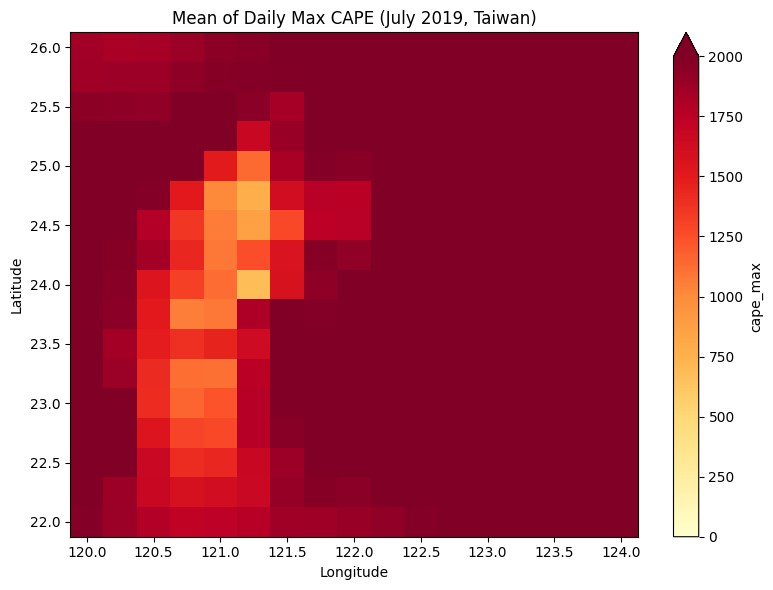

In [6]:
# 計算月平均
cape_monthly = ds_taiwan_july['cape_max'].mean(dim='time').compute()

# 繪圖
plt.figure(figsize=(8, 6))
cape_monthly.plot(cmap='YlOrRd', vmin=0, vmax=2000)
plt.title('Mean of Daily Max CAPE (July 2019, Taiwan)', fontsize=12)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

## 2. 多檔案讀取：跨年度分析

### 情境：計算 2019-2023 年的氣候態

氣候態（climatology）= 多年平均的季節變化。例如：
- 1 月的平均 CAPE
- 7 月的平均 BLH

這需要讀取所有年份的資料。

### 方法 1：逐年讀取並串接

In [7]:
# 沿著時間軸串接
ds_all = catalog.era5_all_years.to_dask()
print(ds_all)

<xarray.Dataset> Size: 109GB
Dimensions:                                (time: 43824, latitude: 121,
                                            longitude: 161, level: 4)
Coordinates:
  * time                                   (time) datetime64[ns] 351kB 2019-0...
  * latitude                               (latitude) float32 484B 40.0 ... 10.0
  * longitude                              (longitude) float32 644B 100.0 ......
  * level                                  (level) int64 32B 300 500 700 850
Data variables: (12/17)
    100m_u_component_of_wind               (time, latitude, longitude) float32 3GB dask.array<chunksize=(360, 121, 161), meta=np.ndarray>
    100m_v_component_of_wind               (time, latitude, longitude) float32 3GB dask.array<chunksize=(360, 121, 161), meta=np.ndarray>
    10m_u_component_of_wind                (time, latitude, longitude) float32 3GB dask.array<chunksize=(360, 121, 161), meta=np.ndarray>
    10m_v_component_of_wind                (time, latitude

### 重要：這裡沒有載入資料！

雖然我們「串接」了 5 年資料（~100 GB），但實際上：
- **沒有讀取任何 Zarr 檔案**
- **沒有佔用 100 GB 記憶體**
- 只是建立了一個**虛擬的 Dataset**，記錄了資料的位置

這就是 lazy evaluation 的威力。

## 3. 計算氣候態：Groupby 操作

### 什麼是 Groupby？

Groupby 是「split-apply-combine」模式：
1. **Split**：按照某個規則分組（例如按月份）
2. **Apply**：對每組做相同操作（例如計算平均）
3. **Combine**：合併結果

在氣候分析中常用的 groupby：
- `.groupby('time.month')`：按月份分組（1-12月）
- `.groupby('time.season')`：按季節分組（DJF, MAM, JJA, SON）
- `.groupby('time.dayofyear')`：按一年中的第幾天（1-365）

In [8]:
# 計算每個月份的氣候態（5 年平均）
cape_climatology = ds_all['convective_available_potential_energy'].groupby('time.month').mean(dim='time')

print("CAPE Climatology:")
print(cape_climatology)
print()
print(f"Dimensions: {cape_climatology.dims}")
print(f"Shape: {cape_climatology.shape}")
print(f"Coordinates: {list(cape_climatology.coords)}")

CAPE Climatology:
<xarray.DataArray 'convective_available_potential_energy' (month: 12,
                                                           latitude: 121,
                                                           longitude: 161)> Size: 935kB
dask.array<stack, shape=(12, 121, 161), dtype=float32, chunksize=(1, 121, 161), chunktype=numpy.ndarray>
Coordinates:
  * month      (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * latitude   (latitude) float32 484B 40.0 39.75 39.5 39.25 ... 10.5 10.25 10.0
  * longitude  (longitude) float32 644B 100.0 100.2 100.5 ... 139.5 139.8 140.0
Attributes:
    long_name:   Convective available potential energy
    short_name:  cape
    units:       J kg**-1

Dimensions: ('month', 'latitude', 'longitude')
Shape: (12, 121, 161)
Coordinates: ['latitude', 'longitude', 'month']


### 理解結果

原本的維度：`(time, latitude, longitude)`
- time: 43800 (5 years * 8760 hours)

Groupby 後的維度：`(month, latitude, longitude)`
- month: 12

每個月份的值 = 5 年中所有該月份資料的平均。

### 3.1 計算並繪製季節變化

In [10]:
# 選取台灣區域，計算氣候態
cape_taiwan = ds_all['convective_available_potential_energy'].sel(
    latitude=slice(26, 22),
    longitude=slice(120, 124)
)

# 計算區域平均的月氣候態
cape_monthly_clim = cape_taiwan.groupby('time.month').mean(dim=['time', 'latitude', 'longitude'])

# 執行計算
result = cape_monthly_clim

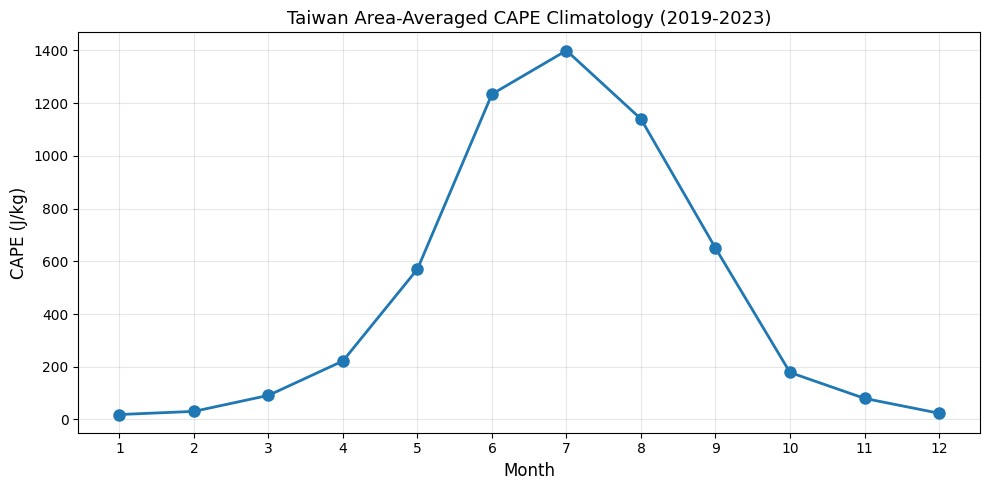

Interpretation:
  Max CAPE month: 7
  Min CAPE month: 1
  Summer mean (JJA): 1258 J/kg
  Winter mean (DJF): 24 J/kg


In [11]:
# 繪圖
plt.figure(figsize=(10, 5))
result.plot(marker='o', linewidth=2, markersize=8)
plt.xlabel('Month', fontsize=12)
plt.ylabel('CAPE (J/kg)', fontsize=12)
plt.title('Taiwan Area-Averaged CAPE Climatology (2019-2023)', fontsize=13)
plt.grid(alpha=0.3)
plt.xticks(range(1, 13))
plt.tight_layout()
plt.show()

print("Interpretation:")
print(f"  Max CAPE month: {result.values.argmax() + 1}")
print(f"  Min CAPE month: {result.values.argmin() + 1}")
print(f"  Summer mean (JJA): {result.sel(month=[6,7,8]).mean().values:.0f} J/kg")
print(f"  Winter mean (DJF): {result.sel(month=[12,1,2]).mean().values:.0f} J/kg")

## 4. 空間統計：計算 Gradient

在氣象分析中，變數的空間梯度（gradient）很重要：
- **溫度梯度**：鋒面位置
- **CAPE 梯度**：對流邊界

Xarray 提供 `.differentiate()` 來計算導數。

Gradient calculation (still lazy):
  Type: <class 'dask.array.core.Array'>
  Shape: (121, 161)


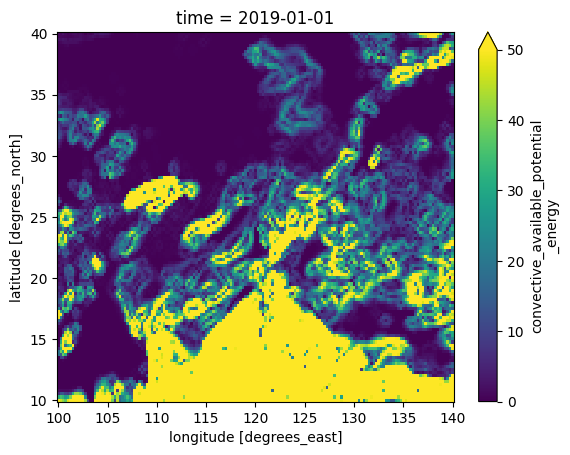

In [12]:
# 選取一個時間點
cape_snapshot = ds_all['convective_available_potential_energy'].isel(time=0)

# 計算經向（latitude）梯度
# 單位：CAPE per degree latitude
cape_grad_lat = cape_snapshot.differentiate('latitude')

# 計算緯向（longitude）梯度
cape_grad_lon = cape_snapshot.differentiate('longitude')

# 計算梯度強度（magnitude）
cape_grad_mag = np.sqrt(cape_grad_lat**2 + cape_grad_lon**2)

print("Gradient calculation (still lazy):")
print(f"  Type: {type(cape_grad_mag.data)}")
print(f"  Shape: {cape_grad_mag.shape}")

cape_grad_mag.plot(cmap='viridis', vmin=0, vmax=50)

## 5. 觀察 Chunking 問題

### 為什麼 Chunking 很重要？

在開始 rechunking 之前，讓我們先看看**錯誤的 chunking** 會造成什麼問題。

我們的 ERA5 資料有一個 chunking 問題：
- 原始全球資料的 chunks: `(1, 721, 1440)`
- subset 到我們區域後變成: `(1, 121, 161)`
- 這代表 **8760 個微小 chunks**（每個時間步一個）

這會導致：
1. **大量 I/O overhead**：每次操作都要讀取數千個小檔案
2. **Dask 排程成本高**：8760 個 tasks 要管理
3. **Dashboard 滿是黃色 get-items**：可以直接看到問題

### 實驗：比較不同的 chunking

In [13]:
# 讀取「原始 chunking」版本（有問題）
print("=== 原始 Chunking（有問題）===")
ds_raw = catalog.era5_2019_raw.to_dask()
cape_raw = ds_raw['convective_available_potential_energy']

print(f"Chunks: {cape_raw.chunks}")
print(f"Number of chunks: {cape_raw.data.npartitions}")

# 計算第一個 chunk 的大小
chunk_size_bytes = 1 * 121 * 161 * 4  # (1, 121, 161) * float32
chunk_size_kb = chunk_size_bytes / 1024
print(f"Single chunk size: {chunk_size_kb:.1f} KB")

if chunk_size_kb < 100:
    print("⚠️  WARNING: Chunks太小！（< 100 KB）")
    print("   這會導致大量 overhead 和 Dashboard 的黃色 get-items\n")

# 讀取「優化 chunking」版本（透過 catalog rechunk）
print("=== 優化 Chunking（catalog rechunk）===")
ds_optimized = catalog.era5_2019_chunked.to_dask()
cape_opt = ds_optimized['convective_available_potential_energy']

print(f"Chunks: {cape_opt.chunks}")
print(f"Number of chunks: {cape_opt.data.npartitions}")

chunk_size_bytes = 744 * 121 * 161 * 4
chunk_size_mb = chunk_size_bytes / (1024**2)
print(f"Single chunk size: {chunk_size_mb:.1f} MB")

if 10 <= chunk_size_mb <= 100:
    print("✓ Chunk size 在理想範圍（10-100 MB）")

print(f"\n改善：{cape_raw.data.npartitions / cape_opt.data.npartitions:.0f}x 減少 chunks 數量")

=== 原始 Chunking（有問題）===
Chunks: ((1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

### Dashboard 觀察

執行一個簡單計算，觀察兩者差異：

**原始 chunking**：會看到大量黃色塊（get-items）  
**優化 chunking**：乾淨的計算圖，少量 tasks

In [14]:
import time

# 小範圍測試（避免等太久）
subset_raw = cape_raw.isel(time=slice(0, 100))  # 前 100 個時間步
subset_opt = cape_opt.isel(time=slice(0, 100))

print("計算中...請觀察 Dashboard 的 Task Stream")
print("\n原始 chunking:")
t0 = time.time()
result_raw = subset_raw.mean().compute()
time_raw = time.time() - t0
print(f"  耗時: {time_raw:.2f}s")

print("\n優化 chunking:")
t0 = time.time()
result_opt = subset_opt.mean().compute()
time_opt = time.time() - t0
print(f"  耗時: {time_opt:.2f}s")

print(f"\n加速: {time_raw / time_opt:.1f}x")

計算中...請觀察 Dashboard 的 Task Stream

原始 chunking:
  耗時: 0.95s

優化 chunking:
  耗時: 0.05s

加速: 19.1x


In [15]:
# Step 1: 選取小範圍資料
print("Step 1: 選取台灣區域的 7 月資料")

# 使用原始的 raw dataset (有問題的 chunking)
ds_subset = ds_raw.sel(
    time='2019-07',  # 7月：744 個時間步
    latitude=slice(26, 22),  # 台灣緯度範圍
    longitude=slice(120, 122)  # 台灣經度範圍
)

print(f"Subset shape: {ds_subset['convective_available_potential_energy'].shape}")
print(f"Subset size: {ds_subset.nbytes / (1024**2):.1f} MB")
print(f"Current chunks: {ds_subset['convective_available_potential_energy'].chunks}")
print(f"Number of chunks: {ds_subset['convective_available_potential_energy'].data.npartitions}")
print("\n⚠️  注意：這個資料有 744 個微小 chunks（每個時間步一個）")

Step 1: 選取台灣區域的 7 月資料
Subset shape: (744, 17, 9)
Subset size: 13.9 MB
Current chunks: ((1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [16]:
# Step 1: 使用 Rechunker 重新儲存
from rechunker import rechunk
import tempfile
import shutil

# 定義目標 chunks
# 策略：完整的空間維度 + 合理的時間 chunks
target_chunks = {
    'time': 360,  # 15天（半個月）
    'latitude': -1,  
    'longitude': -1
}

# 計算預期的 chunk size
expected_chunk_size = 360 * 4 * 2 * 4 * 4  # time × lat × lon × variables × float32
print(f"Expected single chunk size: {expected_chunk_size / (1024**2):.2f} MB")
print()

# 輸出路徑
output_zarr = 'outputs/era5_tw_rechunked.zarr'
temp_zarr = 'outputs/temp_tw_rechunk.zarr'

# 清理舊檔案（如果存在）
for path in [output_zarr, temp_zarr]:
    if Path(path).exists():
        shutil.rmtree(path)
        print(f"Removed old: {path}")

# 使用 rechunker
rechunk_plan = rechunk(
    ds_subset,
    target_chunks=target_chunks,
    max_mem='3GB',  # 限制記憶體使用
    target_store=output_zarr,
    temp_store=temp_zarr
)
rechunk_plan.execute()

# 清理臨時檔案
shutil.rmtree(temp_zarr)

print("\n✓ Rechunking 完成！")

Expected single chunk size: 0.04 MB

Removed old: outputs/era5_tw_rechunked.zarr

✓ Rechunking 完成！


## 5.1 動手練習：使用 Rechunker 永久修復

### 問題：catalog rechunk 只是暫時方案

目前我們透過 `catalog.yaml` 的 `chunks` 參數來解決問題：
```yaml
era5_2019:
  args:
    chunks: {'time': 744, 'latitude': 121, 'longitude': 161}
```

但這有缺點：
- ❌ **每次讀取都要 rechunk**：浪費 CPU 和時間
- ❌ **無法避免讀取原始小 chunks**：I/O overhead 依然存在
- ❌ **治標不治本**：原始 Zarr 的 chunking 依然是錯的

### 解決方案：使用 Rechunker 永久修復

`rechunker` library 可以：
- ✅ 讀取原始資料一次
- ✅ 重新組織為最佳 chunks
- ✅ 儲存為新的 Zarr（永久優化）
- ✅ 使用臨時儲存空間，避免記憶體爆炸

### 實作：Rechunk 台灣區域的 7 月資料

我們會：
1. 選取小範圍資料（台灣，2019年7月）
2. 使用 rechunker 正確儲存
3. 驗證 chunks 是否正確
4. 比較檔案大小

## 5. Rechunking：最佳化 Chunk 策略

### 為什麼需要 Rechunk？

原始 Zarr 的 chunking 是 `(744, 121, 161)`（時間約 1 個月）。

這適合：
- ✅ 計算時間平均、時間序列分析
- ✅ 空間場的操作

但**不適合**：
- ❌ 單點或小區域的長時間序列
- ❌ ML training（需要時間維度切小塊）

### Rechunking 的成本

Rechunking **不是免費的**：
- 需要讀取所有原始資料
- 重新組織並寫入新的 chunks
- I/O intensive（可能需要數小時）

因此：
1. **先確定分析模式**再 rechunk
2. Rechunk 的結果應該**儲存下來**，不要每次都重新算
3. 使用 intermediate Zarr 作為中間產物

### 5.1 情境：為 ML Training 最佳化

對於後續的 ML pipeline，我們需要：
- 小的時間 batch（例如 32 time steps）
- 完整的空間 patch（例如 16x16）

理想的 chunking：`(32, 16, 16)`

In [18]:
# 使用 daily mean 資料（已經從 hourly 降到 daily）
ds_daily_all = ds_all.resample(time='1D').mean()

print("Before rechunk:")
print(f"  Original chunks: {ds_daily_all['convective_available_potential_energy'].chunks}")
print(f"  Total size: {ds_daily_all.nbytes / 1e9:.2f} GB")
print()

# Rechunk 為適合 ML 的結構
ds_rechunked = ds_daily_all.chunk({
    'time': 32,        # 每個 batch 32 天
    'latitude': 16,    # 16x16 空間 patch
    'longitude': 16
})

print("After rechunk:")
print(f"  New chunks: {ds_rechunked['convective_available_potential_energy'].chunks}")
print(f"  Number of chunks: {ds_rechunked['convective_available_potential_energy'].data.npartitions}")
print()

# 計算單一 chunk 的大小
chunk_size = 32 * 16 * 16 * 4  # float32 = 4 bytes
print(f"Single chunk size: {chunk_size / 1024:.2f} KB")
print(f"  Status: {chunk_size / (1024**2):.2f} MB - 在理想範圍內 (10-100 MB)")

Before rechunk:
  Original chunks: ((1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

### Chunk Size 的權衡

| Chunk Size | 優點 | 缺點 | 適用情境 |
|------------|------|------|----------|
| < 1 MB | 極細粒度平行化 | Overhead 過大 | 不推薦 |
| 1-10 MB | 高度平行化 | 排程成本仍高 | 大量 workers |
| **10-100 MB** | **平衡** | **- ** | **大多數情況** |
| 100-500 MB | 低 overhead | 平行度受限 | 少量複雜計算 |
| > 500 MB | 最低 overhead | 記憶體壓力、無法平行 | 不推薦 |

我們的 32 KB 太小了！讓我們調整：

In [20]:
# 更合理的 chunking
ds_rechunked = ds_daily_all.chunk({
    'time': 32,        # 32 天
    'latitude': 60,    # 60 個緯度點
    'longitude': 80    # 80 個經度點
})

chunk_size = 32 * 60 * 80 * 4 * 4  # 4 variables, float32
print(f"Optimized chunk size: {chunk_size / (1024**2):.2f} MB")
print(f"Number of chunks per variable: {ds_rechunked['convective_available_potential_energy'].data.npartitions}")
print(f"Total chunks (4 variables): {ds_rechunked['convective_available_potential_energy'].data.npartitions * 4}")

Optimized chunk size: 2.34 MB
Number of chunks per variable: 522
Total chunks (4 variables): 2088


## 6. 儲存為 Zarr：固化中間結果

### 為什麼要儲存中間結果？

假設我們的 workflow 是：
1. 讀取 5 年 hourly 資料
2. Resample 到 daily
3. Rechunk
4. 用於 ML training

如果每次 training 都重複 1-3 步驟：
- 每次都要讀取 ~135 GB 原始資料
- 重複計算 resample（耗費 CPU）
- 重複 rechunk（大量 I/O）

**更好的做法**：
1. 算一次 daily + rechunked 資料
2. 儲存為新的 Zarr（可能 ~6 GB）
3. 後續直接讀取這個優化過的 Zarr

### 6.1 準備要儲存的資料

In [21]:
# 選取小範圍資料：台灣區域 + 7月 + 只選幾個變數
# 這樣儲存會快很多，適合示範用途
ds_to_save = ds.sel(
    time='2019-07',  # 只選 7 月（31 天）
    latitude=slice(26, 22),  # 台灣緯度
    longitude=slice(120, 124)  # 台灣經度
)[['convective_available_potential_energy', 
   'convective_inhibition', 
   'k_index', 
   'boundary_layer_height']]  # 只選 4 個變數

# Resample 到 daily
ds_to_save = ds_to_save.resample(time='1D').mean()

# Rechunk 到適合的結構
ds_to_save = ds_to_save.chunk({
    'time': 31,  # 整個 7 月
    'latitude': 17,  # 完整的緯度範圍
    'longitude': 17   # 完整的經度範圍
})

print("Dataset to save (小範圍示範):")
print(ds_to_save)
print()
print(f"Size: {ds_to_save.nbytes / (1024**2):.2f} MB")
print("這是一個小範圍的示範資料，儲存會很快！")

Dataset to save (小範圍示範):
<xarray.Dataset> Size: 144kB
Dimensions:                                (time: 31, latitude: 17,
                                            longitude: 17)
Coordinates:
  * time                                   (time) datetime64[ns] 248B 2019-07...
  * latitude                               (latitude) float32 68B 26.0 ... 22.0
  * longitude                              (longitude) float32 68B 120.0 ... ...
Data variables:
    convective_available_potential_energy  (time, latitude, longitude) float32 36kB dask.array<chunksize=(31, 17, 17), meta=np.ndarray>
    convective_inhibition                  (time, latitude, longitude) float32 36kB dask.array<chunksize=(31, 17, 17), meta=np.ndarray>
    k_index                                (time, latitude, longitude) float32 36kB dask.array<chunksize=(31, 17, 17), meta=np.ndarray>
    boundary_layer_height                  (time, latitude, longitude) float32 36kB dask.array<chunksize=(31, 17, 17), meta=np.ndarray>
Attr

### 6.2 儲存為 Zarr

Zarr 的儲存參數：

1. **mode='w'**: 覆寫模式（小心！會刪除舊資料）
2. **consolidated=True**: 將 metadata 集中儲存
   - 優點：減少讀取時的 HTTP requests（雲端友善）
   - 缺點：不支援 append（對我們沒影響）
3. **encoding**: 設定壓縮、chunking
   - compressor: 使用 Blosc 壓縮（CPU-friendly）
   - chunks: 明確指定 chunk shape

In [ ]:
from numcodecs import Blosc

output_path = 'outputs/era5_taiwan_july_daily.zarr'
# 設定 encoding（壓縮與 chunking）
compressor = Blosc(cname='zstd', clevel=3, shuffle=Blosc.SHUFFLE)

encoding = {
    var: {
        'compressor': compressor,
        'chunks': (31, 17, 17)  # 明確指定 chunk shape
    }
    for var in ds_to_save.data_vars
}

print("Saving to Zarr...")
print(f"  Output: {output_path}")
print(f"  Compressor: Blosc (zstd, level 3)")
print(f"  Chunks: (31, 17, 17)")
print(f"  Size: ~{ds_to_save.nbytes / (1024**2):.2f} MB (小檔案，儲存很快！)")
print()

# 執行儲存
# compute=True: 立即執行（而不是 lazy）
# consolidated=True: 建立 .zmetadata
ds_to_save.to_zarr(
    output_path,
    mode='w',
    encoding=encoding,
    consolidated=True
)

print("✓ Saved successfully!")

Saving to Zarr...
  Output: outputs/era5_taiwan_july_daily.zarr
  Compressor: Blosc (zstd, level 3)
  Chunks: (31, 17, 17)
  Size: ~0.14 MB (小檔案，儲存很快！)

✓ Saved successfully!


### 儲存過程說明

這個操作會：
1. **讀取原始 Zarr**：只讀取台灣區域 7 月的資料（很小！）
2. **執行 resample**：hourly → daily mean
3. **壓縮**：使用 Blosc 壓縮（約 30-50% 壓縮率）
4. **寫入新 Zarr**：到 `outputs/` 目錄
5. **建立 consolidated metadata**：加速後續讀取

**注意**：這裡我們儲存的是**小範圍示範資料**（台灣 7 月），所以只需要**幾秒鐘**！
如果要儲存完整的 2019 年全區域資料，會需要數分鐘到數十分鐘。

**觀察建議**：切換到 Dask Dashboard 的 Task Stream，看到平行的 read → compute → write 任務。

### 6.3 驗證儲存結果

In [23]:
# 重新讀取剛儲存的 Zarr
ds_loaded = xr.open_zarr(output_path, consolidated=True)

print("Loaded dataset:")
print(ds_loaded)
print()
print(f"Chunks: {ds_loaded['convective_available_potential_energy'].chunks}")
print()

# 驗證資料正確性：計算一個簡單統計量
original_mean = ds_to_save['convective_available_potential_energy'].mean().compute()
loaded_mean = ds_loaded['convective_available_potential_energy'].mean().compute()

print("Verification:")
print(f"  Original mean: {original_mean.values:.2f}")
print(f"  Loaded mean: {loaded_mean.values:.2f}")
print(f"  Difference: {abs(original_mean.values - loaded_mean.values):.6f}")
print(f"  Status: {'✓ Match' if abs(original_mean.values - loaded_mean.values) < 0.01 else '✗ Mismatch'}")

Loaded dataset:
<xarray.Dataset> Size: 144kB
Dimensions:                                (time: 31, latitude: 17,
                                            longitude: 17)
Coordinates:
  * time                                   (time) datetime64[ns] 248B 2019-07...
  * latitude                               (latitude) float32 68B 26.0 ... 22.0
  * longitude                              (longitude) float32 68B 120.0 ... ...
Data variables:
    boundary_layer_height                  (time, latitude, longitude) float32 36kB dask.array<chunksize=(31, 17, 17), meta=np.ndarray>
    convective_available_potential_energy  (time, latitude, longitude) float32 36kB dask.array<chunksize=(31, 17, 17), meta=np.ndarray>
    convective_inhibition                  (time, latitude, longitude) float32 36kB dask.array<chunksize=(31, 17, 17), meta=np.ndarray>
    k_index                                (time, latitude, longitude) float32 36kB dask.array<chunksize=(31, 17, 17), meta=np.ndarray>
Attributes:
 

### 6.4 檢查磁碟空間使用

In [28]:
import subprocess

# 使用 du 指令查看目錄大小
result = subprocess.run(
    ['du', '-sh', output_path],
    capture_output=True,
    text=True
)

print(f"Disk usage: {result.stdout.strip()}")
print()
print("Comparison:")
print(f"  Original (7月 hourly, 4 variables): ~{ds_to_save.nbytes * 24 / (1024**2):.1f} MB (未壓縮)")
print(f"  Saved (7月 daily, compressed): {result.stdout.split()[0]}")

Disk usage: 196K	outputs/era5_taiwan_july_daily.zarr

Comparison:
  Original (7月 hourly, 4 variables): ~3.3 MB (未壓縮)
  Saved (7月 daily, compressed): 196K


## 7. 壓縮選項比較

不同的壓縮器有不同的權衡：

| Compressor | 壓縮率 | 壓縮速度 | 解壓速度 | 適用情境 |
|------------|--------|----------|----------|----------|
| None | 1.0x | - | - | 快速原型、SSD |
| Blosc (lz4) | 2-3x | 極快 | 極快 | 預設選擇 |
| **Blosc (zstd)** | **3-5x** | **快** | **快** | **推薦** |
| gzip | 4-6x | 慢 | 中 | 長期封存、網路傳輸 |
| zlib | 3-5x | 慢 | 中 | 相容性優先 |

**我們使用 Blosc (zstd, level=3)**：
- 平衡壓縮率與速度
- CPU overhead 低（重要！因為我們還要做計算）
- 解壓快速（讀取時不會成為瓶頸）

如果需要更高壓縮率（例如資料要傳輸到其他地方），可以用：
```python
compressor = Blosc(cname='zstd', clevel=9, shuffle=Blosc.BITSHUFFLE)
```

## 8. 檢查點：你應該理解的概念

完成這個 notebook 後，你應該能夠：

- [ ] 使用 `.resample()` 進行時間聚合
- [ ] 使用 `.groupby()` 計算氣候態
- [ ] 用 `xr.concat()` 串接多個 Dataset
- [ ] 理解 rechunking 的時機和成本
- [ ] 根據分析模式選擇合適的 chunk size
- [ ] 正確設定壓縮參數並儲存 Zarr
- [ ] 使用 consolidated metadata 加速讀取

### Workflow 總結

處理大型 N-D array 的標準流程：

```
原始資料 (Zarr)
    ↓ (lazy operations)
選取 / 切片 / 聚合
    ↓
Rechunk（如果需要）
    ↓ (.to_zarr())
優化的中間 Zarr
    ↓ (用於後續分析)
ML / 視覺化 / 統計
```

關鍵：**把耗時的前處理做一次，儲存下來，重複使用**。

## 9. 小練習（可選）

1. **計算季節氣候態**：使用 `.groupby('time.season')` 計算 DJF, MAM, JJA, SON 的 CAPE 平均
2. **異常值偵測**：找出 CAPE > 5000 J/kg 的極端事件，統計發生頻率
3. **實驗 chunking**：比較不同 chunk 策略對 `.mean(dim='time')` 的影響
4. **壓縮率測試**：用不同的 compressor 儲存相同資料，比較磁碟空間和速度

## 下一步

在 **Notebook 3** 中，我們會進入 ML Pipeline：
- 定義對流分類任務（什麼時候算「對流」？）
- 使用 xbatcher 產生訓練 batches
- 整合 PyTorch DataLoader
- 訓練一個簡單的 CNN 模型
- 用 xskillscore 進行空間驗證

這是整個 workshop 的高潮，會展示完整的「大型陣列 → ML」工作流。

In [ ]:
# 如果要關閉 Client（釋放資源）
# client.close()